In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Connect to the Google Drive

Mounted at /content/drive


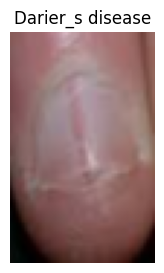

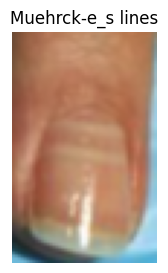

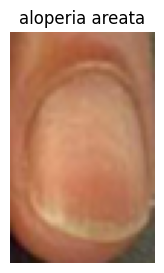

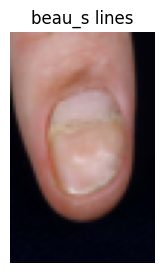

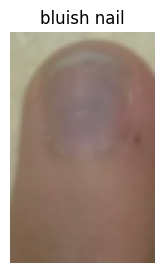

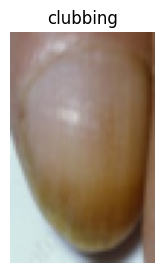

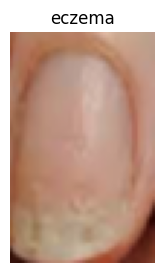

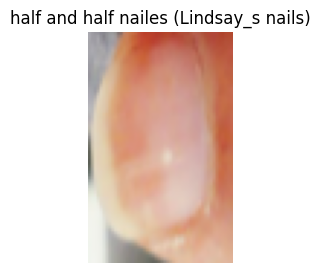

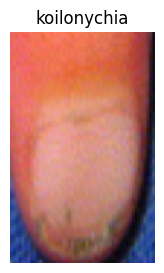

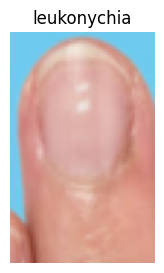

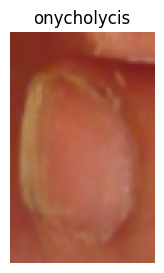

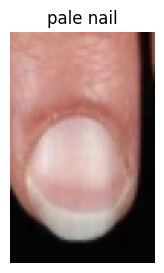

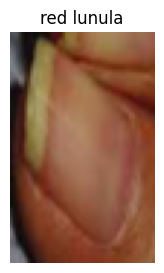

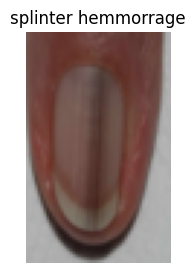

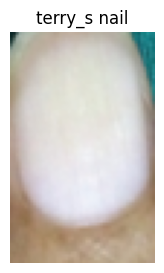

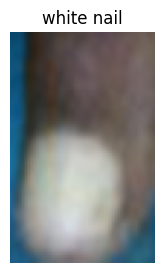

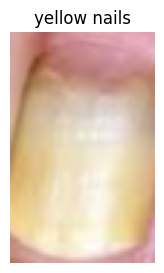

In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Set the path to your dataset
src_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/Dataset1/train"

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((80, 50)),  # Adjust desired_height and desired_width
    transforms.ToTensor(),
])

# Load the dataset
dataset = ImageFolder(root=src_path, transform=transform)

# Map class names to indices
class_to_idx = {class_name: idx for idx, class_name in enumerate(dataset.classes)}

# Create a dataloader for each class
class_dataloaders = []
for class_name in dataset.classes:
    class_indices = [i for i, label in enumerate(dataset.targets) if dataset.classes[label] == class_name]
    class_dataset = torch.utils.data.Subset(dataset, class_indices)
    class_dataloader = DataLoader(class_dataset, batch_size=1, shuffle=True)
    class_dataloaders.append((class_name, class_dataloader))

# Display one image from each class separately
for class_name, class_dataloader in class_dataloaders:
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))

    # Display one image from the current class
    images, labels = next(iter(class_dataloader))
    image_np = images.numpy().squeeze().transpose((1, 2, 0))

    axes.imshow(image_np)
    axes.set_title(class_name)
    axes.axis('off')

    plt.show()


In [ ]:
print(len(dataset))

611


In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define the transformations to resize the images for InceptionV3
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),  # InceptionV3 requires input size of 299x299
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply augmentations to your dataset
src_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/Dataset1/train"
dataset = datasets.ImageFolder(root=src_path, transform=train_transform)

# Load the pre-trained InceptionV3 model
pretrained_model = models.inception_v3(pretrained=True)
# Remove the final fully connected layer of the pre-trained model
pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-1])

# Add your custom fully connected layers for classification
class CustomInceptionV3Model(nn.Module):
    def __init__(self, num_classes=17):
        super(CustomInceptionV3Model, self).__init__()
        # Load the pre-trained InceptionV3 model without the final fully connected layer
        self.features = models.inception_v3(pretrained=True)
        self.features = pretrained_model
        self.fc1 = nn.Linear(2048, 1024)  # Adjusted input size for VGG16
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x





# Load the dataset and split into training and validation sets
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomInceptionV3Model(num_classes=17).to(device)

# Define your loss function and optimizer
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
training_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    training_losses.append(avg_epoch_loss)

    # Validate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct / val_total * 100
    validation_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

# Plot the training losses
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracies
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


RuntimeError: ignored

In [ ]:
src_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/Dataset1/test"

test_dataset = ImageFolder(root=src_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=True)

from sklearn.metrics import confusion_matrix, classification_report



model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)

        all_predictions.extend(test_predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Confusion Matrix:
[[0 0 0 2 6 0 2 0 0 0 0 0 0 7 0 0]
 [0 0 1 2 1 0 2 0 0 0 0 0 0 3 0 0]
 [0 0 1 0 5 0 7 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 1 1 3 0 0 0 0 0 0 3 0 0]
 [0 0 1 1 4 0 3 0 0 1 0 0 0 3 0 0]
 [0 0 0 1 5 1 1 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 2 1 5 0 0 0 0 0 0 4 0 0]
 [0 0 1 0 2 2 3 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 6 0 0]
 [0 0 2 0 6 0 2 0 0 0 0 0 0 2 0 0]
 [0 0 3 0 2 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 2 0 0 0 6 0 0 0 0 0 0 7 0 0]
 [0 0 0 2 2 0 2 0 0 1 0 0 0 3 0 0]
 [0 0 1 2 1 0 2 0 0 0 0 0 0 3 0 0]
 [0 0 1 0 2 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 1 0 1 0 2 0 0 0 0 0 0 4 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00         9
           2       0.07      0.07      0.07        15
           3       0.00      0.00      0.00         8
           4       0.10      0.31      0.15        13
           5       0.20      0.08      0.12        12
           6      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# After your training loop
torch.save(model.state_dict(), "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/VGG16Model.pth")

In [ ]:
from PIL import Image
import torch
from torchvision import transforms
import numpy as np

# Function to load and preprocess an image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to perform inference on a single image
def classify_image(model, image_path, class_labels):
    model.eval()

    # Load and preprocess the image
    image = preprocess_image(image_path)

    # Move image to the same device as the model
    device = next(model.parameters()).device
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)

    # Get the predicted class index
    _, predicted = torch.max(output.data, 1)
    predicted_class = predicted.item()

    # Map the class index to the corresponding label
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Load the trained model
model_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/VGG16Model.pth"
# Load the model architecture
model = CustomVGG16Model(num_classes=7).to(device)

# Load the saved state_dict
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
model.eval()

# Class labels corresponding to your 7 nail diseases
class_labels = ["Acral Lentiginous Melanoma", "Beaus line", "Blue finger", "clubbing", "eczema", "healthy nail", "Onycholysis"]

# Path to the new image you want to classify
new_image_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/Nail Disease datasets/newData/nail2.jpg"

# Perform inference
predicted_disease = classify_image(model, new_image_path, class_labels)

# Display the result
print(f"The predicted disease for the given image is: {predicted_disease}")



NameError: ignored